# Optimizing the design and operation of a two nodal energy system with networks
In this study, we want to look at a two-nodal system in a brownfield manner. We assume two fictous regions with a heat demand and an electricity demand and we want to study the decarbonization of these two regions and the required carbon tax associated with a certain emission reduction. First we will optimize the design and operation of the system without a carbon tax and then study the effect of a carbon tax. The topology of the energy system is depicted below. Brown rectancles mean that the technology is already installed, green retangles mean that the technology can be newly build. Both colors mean that the technology can be expanded.

We assume that there are two nodes: one depicting a city with no options to install wind turbines and no power plant and a rural node with a gas-fired power plant and the option to install wind turbines.

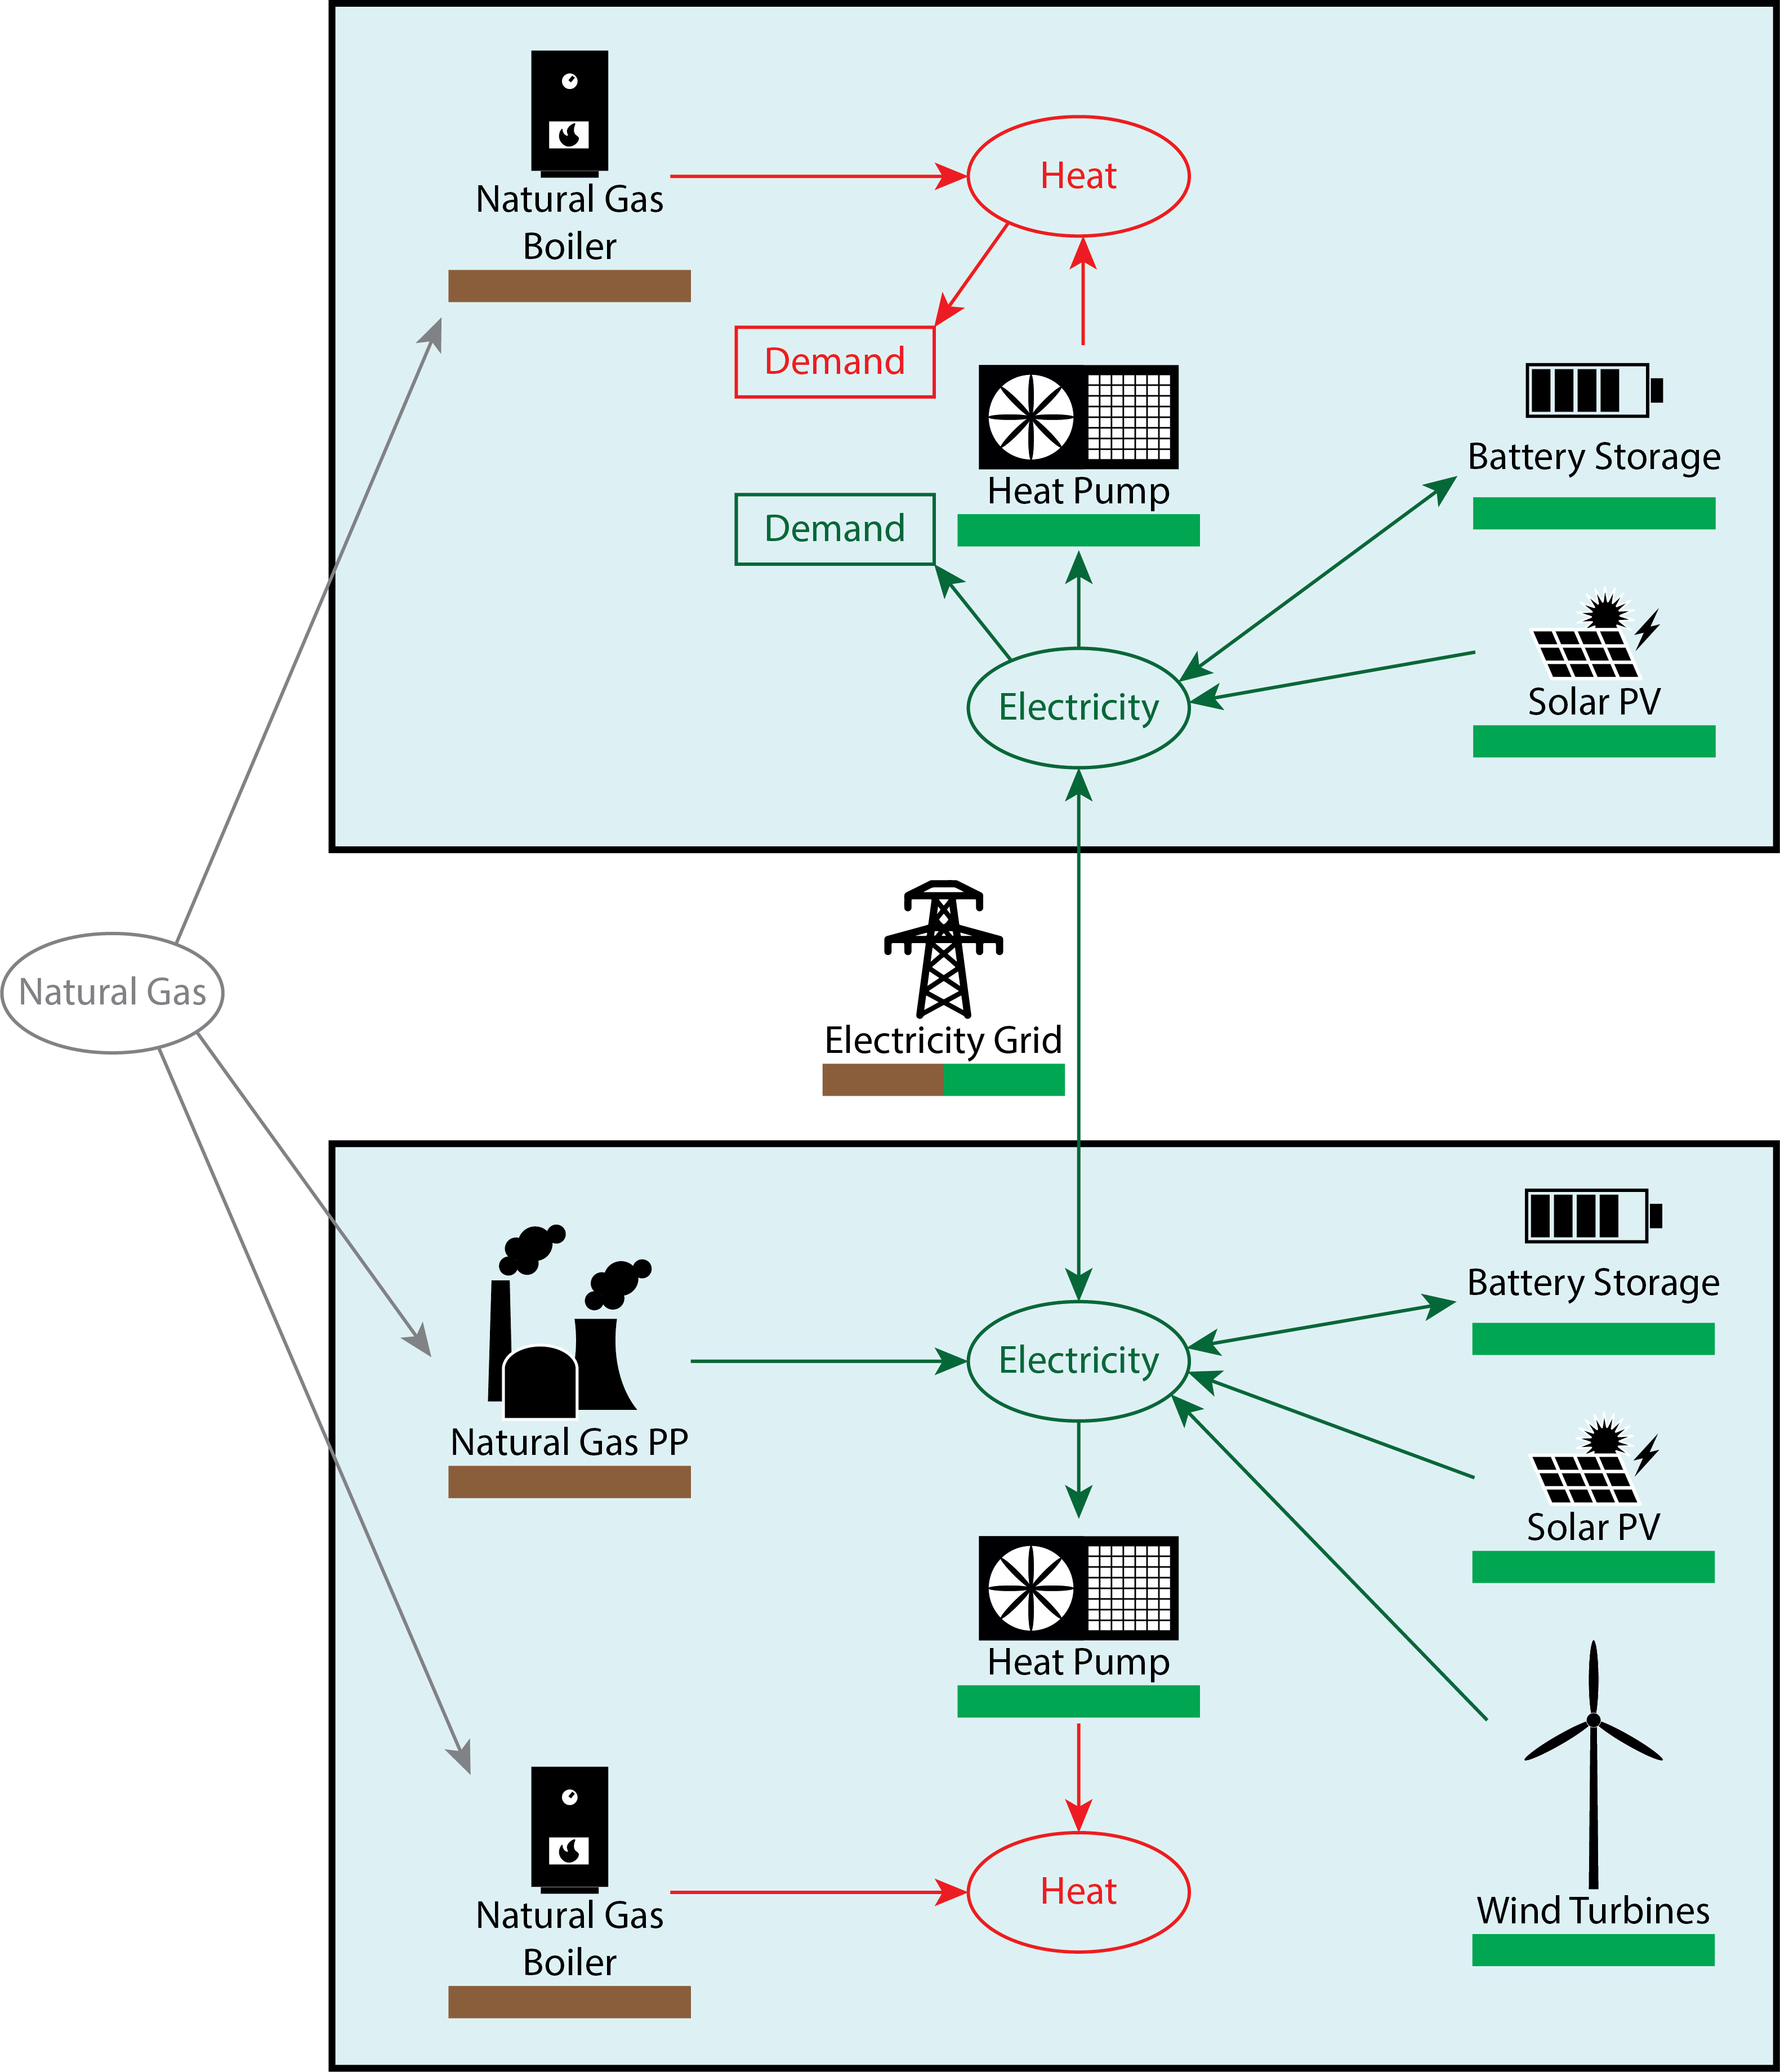

## Create templates
We set the input data path and in this directory we can add input data templates for the model configuration and the topology with the function create_optimization_templates.


In [54]:
import adopt_net0 as adopt
import json
from pathlib import Path
import os
import pandas as pd

input_data_path = Path("./caseStudies/network")
adopt.create_optimization_templates(input_data_path)

Files already exist: caseStudies\network\Topology.json caseStudies\network\ConfigModel.json


## Adapt Topology
We need to adapt the topology as well as the model configuration file to our case study. This can be done either in the file itself (Topology.json) or, as we do it here via some lines of code.
For the topology, we need to change the following:
- Change nodes: city and urban area
- Change carriers: electricity, heat and natural gas (we need to add hydrogen as a carrier as well, as the gas turbine also allows for a hydrogen input, even though we do not use it in this case study)
- Change investment periods: period1
- The options regarding the time frame we can leave at the default (one year with hourly operation)

In [55]:
# Load json template
with open(input_data_path / "Topology.json", "r") as json_file:
    topology = json.load(json_file)
# Nodes
topology["nodes"] = ["city", "rural"]
# Carriers:
topology["carriers"] = ["electricity", "heat", "gas", "hydrogen"]
# Investment periods:
topology["investment_periods"] = ["period1"]
# Save json template
with open(input_data_path / "Topology.json", "w") as json_file:
    json.dump(topology, json_file, indent=4)

## Adapt Model Configurations
The model configuration we leave as it is, except spcifying a number of typical days to speed up the optimization (this system also solves on full resolution, but here, we want to only show how the model works at the expense of precision). Additionallym, we set the milp gap to 2%
- Change the number of typical days to 30 and select time aggregation method 1
- Change the milp gap to 2%

In [56]:
# Load json template
with open(input_data_path / "ConfigModel.json", "r") as json_file:
    configuration = json.load(json_file)
# Set time aggregation settings:
configuration["optimization"]["typicaldays"]["N"]["value"] = 30
configuration["optimization"]["typicaldays"]["method"]["value"] = 1
# Set MILP gap
configuration["solveroptions"]["mipgap"]["value"] = 0.02
# Save json template
with open(input_data_path / "ConfigModel.json", "w") as json_file:
    json.dump(configuration, json_file, indent=4)

## Define new and existing technologies at each node
First we create the required folder structure based on the Topology.json file. and we can show all available technologies with as follows:

In [63]:
adopt.create_input_data_folder_template(input_data_path)
adopt.show_available_technologies()

MEA_large
MEA_medium
MEA_small
DAC_Adsorption
dac_adsorption_performanc
Boiler_El
Boiler_Industrial_NG
Boiler_Small_H2
Boiler_Small_NG
Furnace_H2
Furnace_NG
HeatPump_AirSourced
HeatPump_GroundSourced
HeatPump_WaterSourced
Hydro_Reservoir
PumpedHydro_Closed
PumpedHydro_Open
CrackerFurnace
CrackerFurnace_Electric
EthyleneCompression
EthyleneCompression_Electric
EthyleneSeparation
SteamReformer
SteamReformer_CCS
GasTurbine_H2_10
GasTurbine_H2_100
GasTurbine_H2_250
GasTurbine_H2_400
GasTurbine_NG_10
GasTurbine_NG_100
GasTurbine_NG_250
GasTurbine_NG_400
GasTurbine_simple
GasTurbine_simple_CCS
SteamTurbine
Photovoltaic
SolarThermal
WindTurbine_Offshore_11000
WindTurbine_Offshore_6000
WindTurbine_Offshore_9500
WindTurbine_Onshore_1500
WindTurbine_Onshore_2500
WindTurbine_Onshore_4000
WT_dat
PermanentStorage_CO2_simple
Storage_Battery
Storage_Ethylene
Storage_H2
Storage_H2_Cavern
Storage_HotWater
Storage_NG
Storage_PCM
TemporaryStorage_CO2


... And we can add the technologies that we need to the Technologies.json file at the respective nodes and copy over the required technology data

In [64]:
# Add required technologies for node 'city'
with open(input_data_path / "period1" / "node_data" / "city" / "Technologies.json", "r") as json_file:
    technologies = json.load(json_file)
technologies["new"] = ["HeatPump_AirSourced", "Storage_Battery", "Photovoltaic"]
technologies["existing"] = {"Boiler_Small_NG": 500}

with open(input_data_path / "period1" / "node_data" / "city" / "Technologies.json", "w") as json_file:
    json.dump(technologies, json_file, indent=4)

# Add required technologies for node 'rural'
with open(input_data_path / "period1" / "node_data" / "rural" / "Technologies.json", "r") as json_file:
    technologies = json.load(json_file)
technologies["new"] = ["HeatPump_AirSourced", "Storage_Battery", "Photovoltaic", "WindTurbine_Onshore_4000"]
technologies["existing"] = {"Boiler_Small_NG": 100, "GasTurbine_simple": 1000}

with open(input_data_path / "period1" / "node_data" / "rural" / "Technologies.json", "w") as json_file:
    json.dump(technologies, json_file, indent=4)

# Copy over technology files
adopt.copy_technology_data(input_data_path)

## Define the existing and new electricity network between the two nodes
We can see available networks that ship with the model with:

In [40]:
adopt.show_available_networks()

CO2PipelineOffshore
CO2PipelineOnshore
CO2Railway
CO2Ship
CO2Truck
electricityOffshore
electricityOnshore
electricitySimple
heat
hydrogenPipelineOffshore
hydrogenPipelineOnshore
hydrogenRailway
hydrogenShip
hydrogenSimple
hydrogenTruck


In this case, we will use 'electricityOnshore' for both the existing and new network:

In [65]:
# Add networks
with open(input_data_path / "period1" / "Networks.json", "r") as json_file:
    networks = json.load(json_file)
networks["new"] = ["electricityOnshore"]
networks["existing"] = ["electricityOnshore"]

with open(input_data_path / "period1" / "Networks.json", "w") as json_file:
    json.dump(networks, json_file, indent=4)

Now we need to specify the network topologies for both the existing and the new network and copy them in the respective directory. This is easier done manually, but here we do it using python.
New networks need the following files (size_max_arcs is optional):
- connection.csv (1 or 0)
- distance.csv (distance in km): 50km between the two nodes
  
Existing networks need the following files:
- connection.csv (1 or 0)
- distance.csv (distance in km): 50km between the two nodes
- size.csv (size in MW): 1GW connection

In [66]:
# Make a new folder for the existing network
os.makedirs(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore", exist_ok=True)

print("Existing network")
# Use the templates, fill and save them to the respective directory
# Connection
connection = pd.read_csv(input_data_path / "period1" / "network_topology" / "existing" / "connection.csv", sep=";", index_col=0)
connection.loc["city", "rural"] = 1
connection.loc["rural", "city"] = 1
connection.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "connection.csv")
print("Connection:", connection)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "existing" / "connection.csv")

# Distance
distance = pd.read_csv(input_data_path / "period1" / "network_topology" / "existing" / "distance.csv", sep=";", index_col=0)
distance.loc["city", "rural"] = 50
distance.loc["rural", "city"] = 50
distance.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "distance.csv")
print("Distance:", distance)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "existing" / "distance.csv")

# Size
size = pd.read_csv(input_data_path / "period1" / "network_topology" / "existing" / "size.csv", sep=";", index_col=0)
size.loc["city", "rural"] = 1000
size.loc["rural", "city"] = 1000
size.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "size.csv")
print("Size:", size)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "existing" / "size.csv")


print("New network")
# Make a new folder for the new network
os.makedirs(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore", exist_ok=True)

# Use the templates, fill and save them to the respective directory
# Connection
connection = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "connection.csv", sep=";", index_col=0)
connection.loc["city", "rural"] = 1
connection.loc["rural", "city"] = 1
connection.to_csv(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore" / "connection.csv")
print("Connection:", connection)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "new" / "connection.csv")

# Distance
distance = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "distance.csv", sep=";", index_col=0)
distance.loc["city", "rural"] = 50
distance.loc["rural", "city"] = 50
distance.to_csv(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore" / "distance.csv")
print("Distance:", distance)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "new" / "distance.csv")

# Delete the max_size_arc template
os.remove(input_data_path / "period1" / "network_topology" / "new" / "size_max_arcs.csv")

Existing network
Connection:        city  rural
city      0      1
rural     1      0
Distance:        city  rural
city      0     50
rural    50      0
Size:        city  rural
city      0   1000
rural  1000      0
New network
Connection:        city  rural
city      0      1
rural     1      0
Distance:        city  rural
city      0     50
rural    50      0


## Copy over network data
Copy over network data and change cost data.

In [70]:
adopt.copy_network_data(input_data_path)

with open(input_data_path / "period1" / "network_data"/ "electricityOnshore.json", "r") as json_file:
    network_data = json.load(json_file)

network_data["Economics"]["gamma2"] = 40000
network_data["Economics"]["gamma4"] = 300

with open(input_data_path / "period1" / "network_data"/ "electricityOnshore.json", "w") as json_file:
    json.dump(network_data, json_file, indent=4)

## Define demand, climate data, import limits, import prices
Case with no carbon cost

## Define a carbon cost